In [1]:
from IPython.display import Image
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
workers = 2 # Количество воркеров для сборки датасета
image_size = 64 # Размер входа сети для изображений. Все изображения ресайзятся к нему
nc = 3 # Количество каналов цвета
nz = 100 # Размер латентного вектора (размерность латентного пространства)
ngf = 64 # Size of feature maps in generator
ndf = 64 # Рамер карты признаков для генератора
num_epochs = 1 # Кол-во эпох
lr = 0.05 # Лернингрейт
beta1 = 0.5 # Параметр для оптимизатора Adam
ngpu = 0 # Количество GPU, 0 если считаем на CPU

In [4]:
# Для создания датасета используем класс ImageFolder
dataset = dset.ImageFolder(root='./dcgan/img_align_celeba',
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

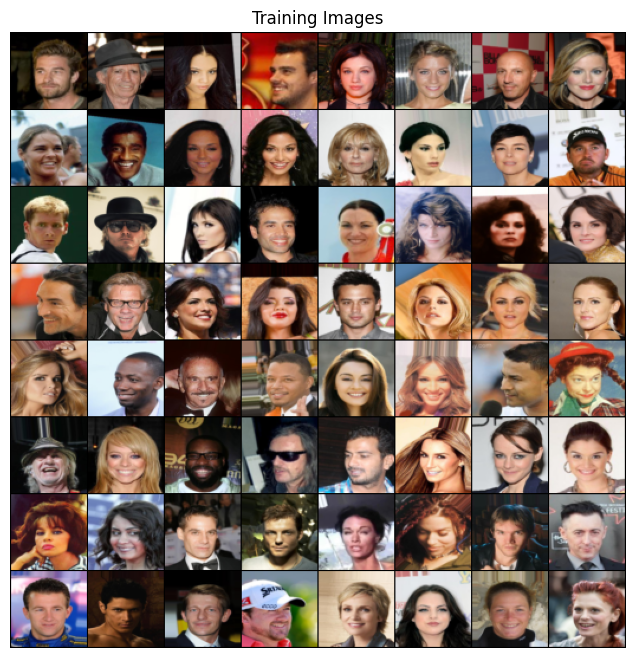

In [9]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, num_workers=workers,
                                        #  shuffle=True,
                                         sampler=torch.utils.data.SubsetRandomSampler(range(int(len(dataset) * 0.01)))
)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
# Нарисуем часть картинок из датасета
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=1, normalize=True).cpu(),(1,2,0)))

In [10]:
# кастомная инициализация весов netG или netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)